# Strategy 

In [23]:
%load_ext zipline
#%%
import talib
import zipline
import os
from zipline.api import order_target, record, symbol, order_target_percent
import pandas as pd 
from zipline.api import order, record, symbol, set_benchmark
from matplotlib import style
import matplotlib.pyplot as plt
from zipline.data.bundles import load
import pyfolio as pf
import numpy as np
from pandas import Timestamp
import matplotlib.pyplot as plt
now = Timestamp.utcnow()
bundle = load('NFTU', os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))

from trading_calendars import get_calendar
print(symbols)
#!zipline ingest --bundle universe
#!zipline clean -b universe --keep-last 1

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
{'FLOW', 'AVAX', 'ADA', 'TFUEL', 'MATIC', 'AMI', 'MANA', 'SOL'}


In [110]:
COINS = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']
status = [False]*len(COINS)
hold_days = [0]*len(COINS)
shortest_period = 20
intial_portfolio = 40000
longest_period = 50
holding_period = 30


# Setup our variables
def initialize(context):
    
    # what stock to trade - FAANG in this example
    # stocklist = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
    COINS = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']

    # make a list of symbols for the list of tickers
    context.coins = [symbol(s) for s in COINS]
    
    # create equal weights of each stock to hold in our portfolio
    context.target_pct_per_coin = 1.0 / len(context.coins)
    
    # create initial RSI threshold values for low (oversold and buy signal) and high (overbought and sell signal)
    context.LOW_RSI = 30
    context.HIGH_RSI = 70
    
    context.holding_days = {COINS[i]: hold_days[i] for i in range(len(COINS))}
    set_benchmark(symbol('AMI'))
    context.i = 0
    
    
# Rebalance daily.
def handle_data(context, data):
    context.i += 1
    
    if context.i < longest_period:
        return
    
    # Load historical pricing data for the stocks, using daily frequncy and a rolling 20 days
    prices = data.history(context.coins, 'price', bar_count=longest_period, frequency="1d")
        
    # trading algorithm
    short_ma = data.history(context.coins, 'close', bar_count=shortest_period, frequency='1d').mean()
    long_ma = data.history(context.coins, 'close', bar_count=longest_period, frequency='1d').mean()

    j=0
    # Loop through our list of stocks
    for coin in context.coins:
  
        
        #Get the rsi of this stock.
        
        current_price = data.current(coin, 'price')
        #rsi = talib.RSI(prices[coin], timeperiod=14)[-1]
        #rsis[coin] = rsi
        avg_20 = prices[coin].mean()
        std = prices[coin].std()
        current_position = context.portfolio.positions[coin].amount
        stop_loss = 0.05
        
        #print(coin, current_position*current_price)
         
        upper_band1 = avg_20 + std
        upper_band2 = avg_20 + 2*std
        lower_band1 = avg_20 - std
        lower_band2 = avg_20 - 2*std
        if current_position > 0:
            context.holding_days[COINS[j]] += 1
            
        #sell signal  and current_price < lower_band1 and current_price > lower_band2       ### or
        if  (short_ma[coin] < long_ma[coin] and current_position > 0 and data.can_trade(coin)) or (context.holding_days[COINS[j]] == holding_period):
            order_target_percent(coin, 0)
            context.holding_days[COINS[j]] = 0
          #  print('Short position')
            
        #buy signal   and current_price > upper_band1 and current_price < upper_band2 
        elif short_ma[coin] > long_ma[coin]  and  current_position == 0   and data.can_trade(coin):
            order_target_percent(coin, context.target_pct_per_coin)
           # print('Long position')
            
        elif (current_price < (1 - stop_loss) * lower_band1) and current_position > 0:
            order_target_percent(coin, 0)
            context.holding_days[COINS[j]] = 0
           # print('Stop loss on long')
        
        elif (current_price > (1 + stop_loss) * upper_band1) and current_position == 0:
            order_target_percent(coin, 0)
            context.holding_days[COINS[j]] = 0
           # print('Stop loss short')
            
        j+=1


    record(SOL=data.current(symbol('SOL'), 'price'),
           TFUEL=data.current(symbol('TFUEL'), 'price'),
           MATIC=data.current(symbol('MATIC'), 'price'),
           FLOW=data.current(symbol('FLOW'), 'price'),
           MANA=data.current(symbol('MANA'), 'price'),
            ADA=data.current(symbol('ADA'), 'price'),
            AVAX=data.current(symbol('AVAX'), 'price'),
           AMI = data.current(symbol('AMI'), 'price'),
          )

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


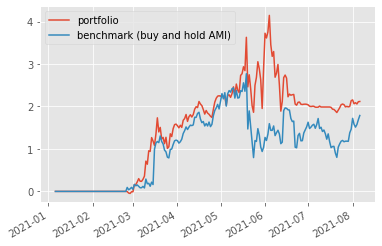

In [111]:
start = pd.Timestamp('2021-01-05', tz='utc')
end = pd.Timestamp('2021-08-05', tz='utc')
#start = pd.Timestamp('2021-01-05', tz='utc')
#end = pd.Timestamp('2022-04-11', tz='utc')

perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
   # analyze=analyze, 
    capital_base=intial_portfolio, 
    handle_data = handle_data,
    trading_calendar=get_calendar('24/7'),
    data_frequency = 'daily', 
    bundle= 'NFTU')
######################
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark (buy and hold AMI)')
plt.legend(loc=2)
plt.show()

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


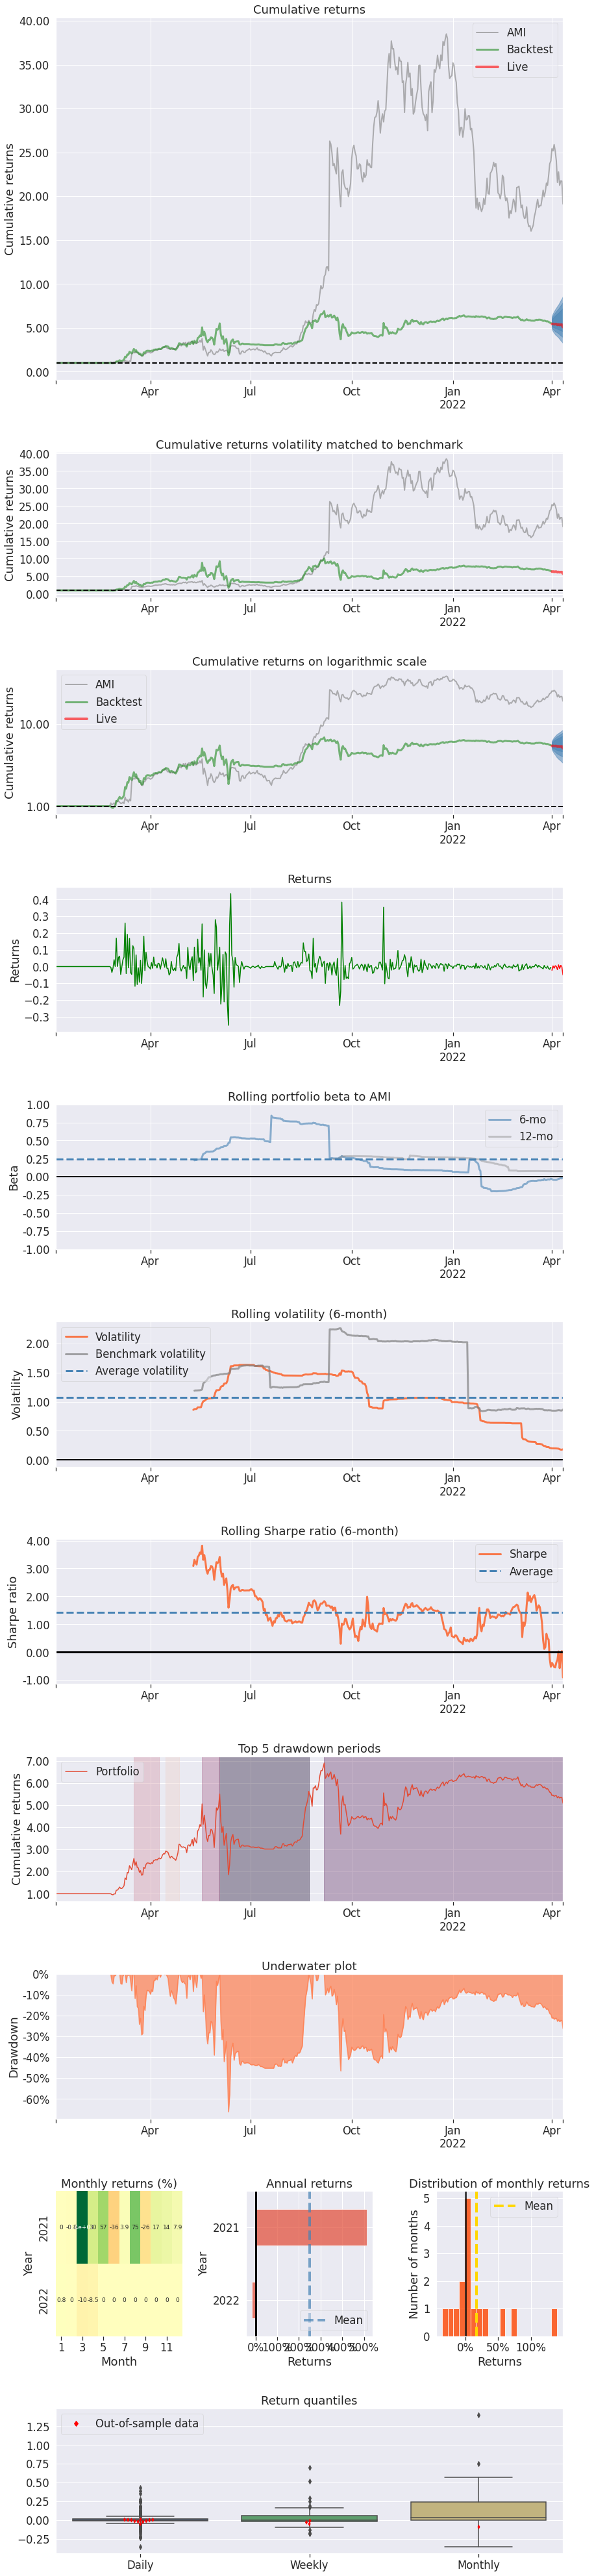

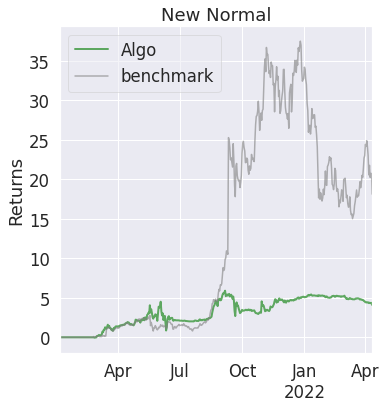

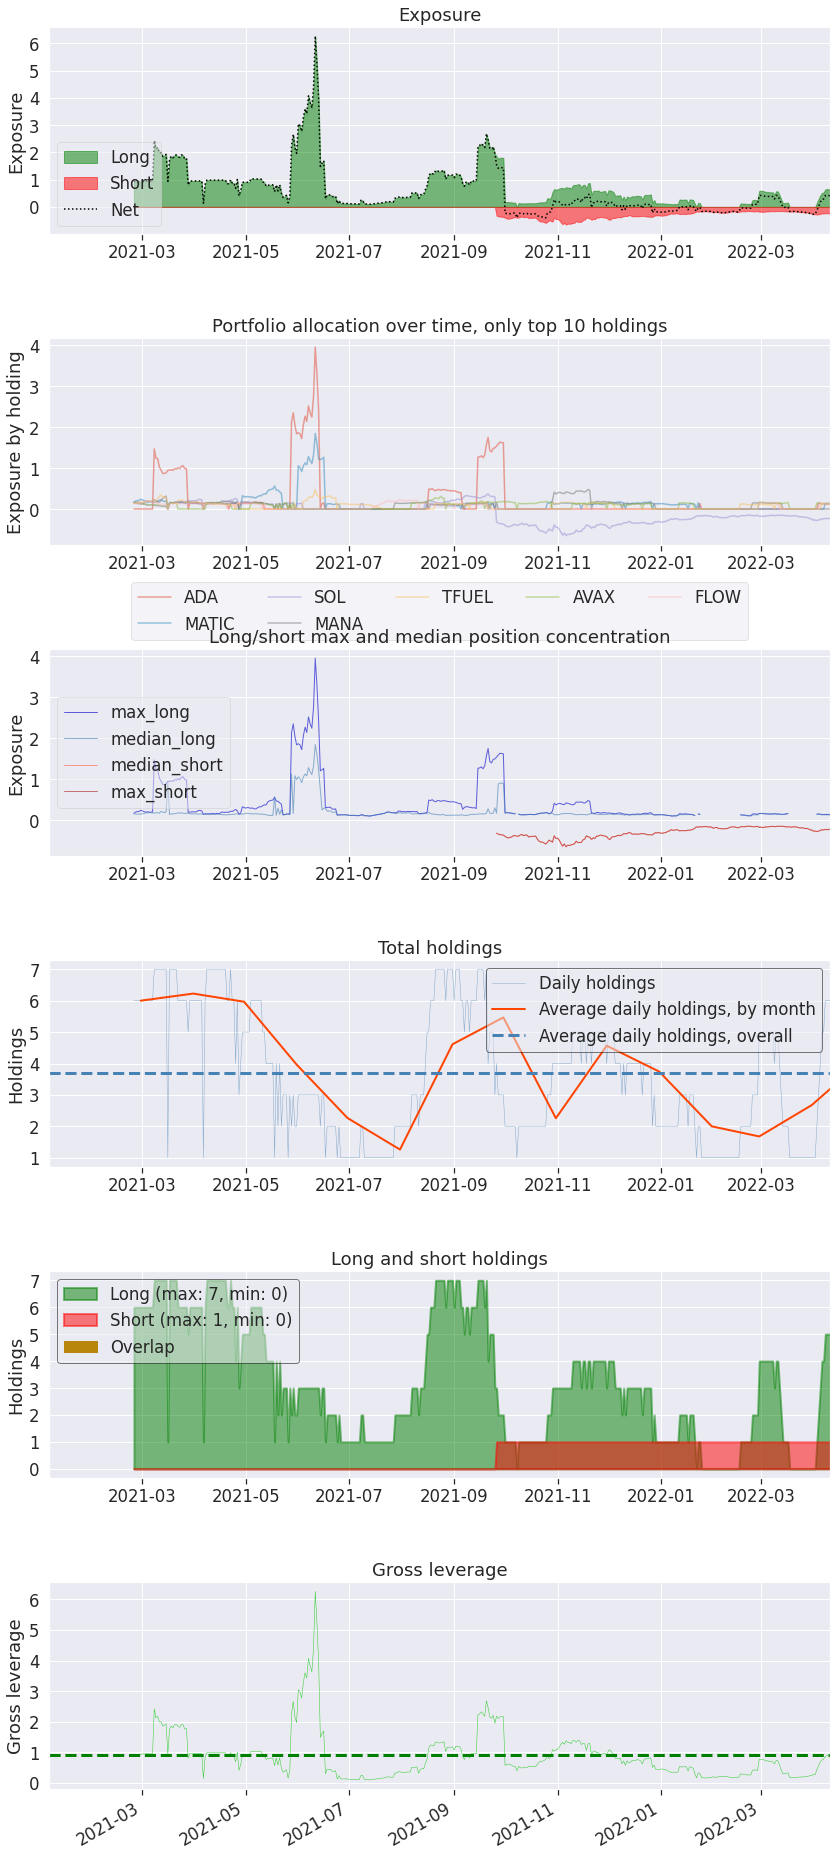

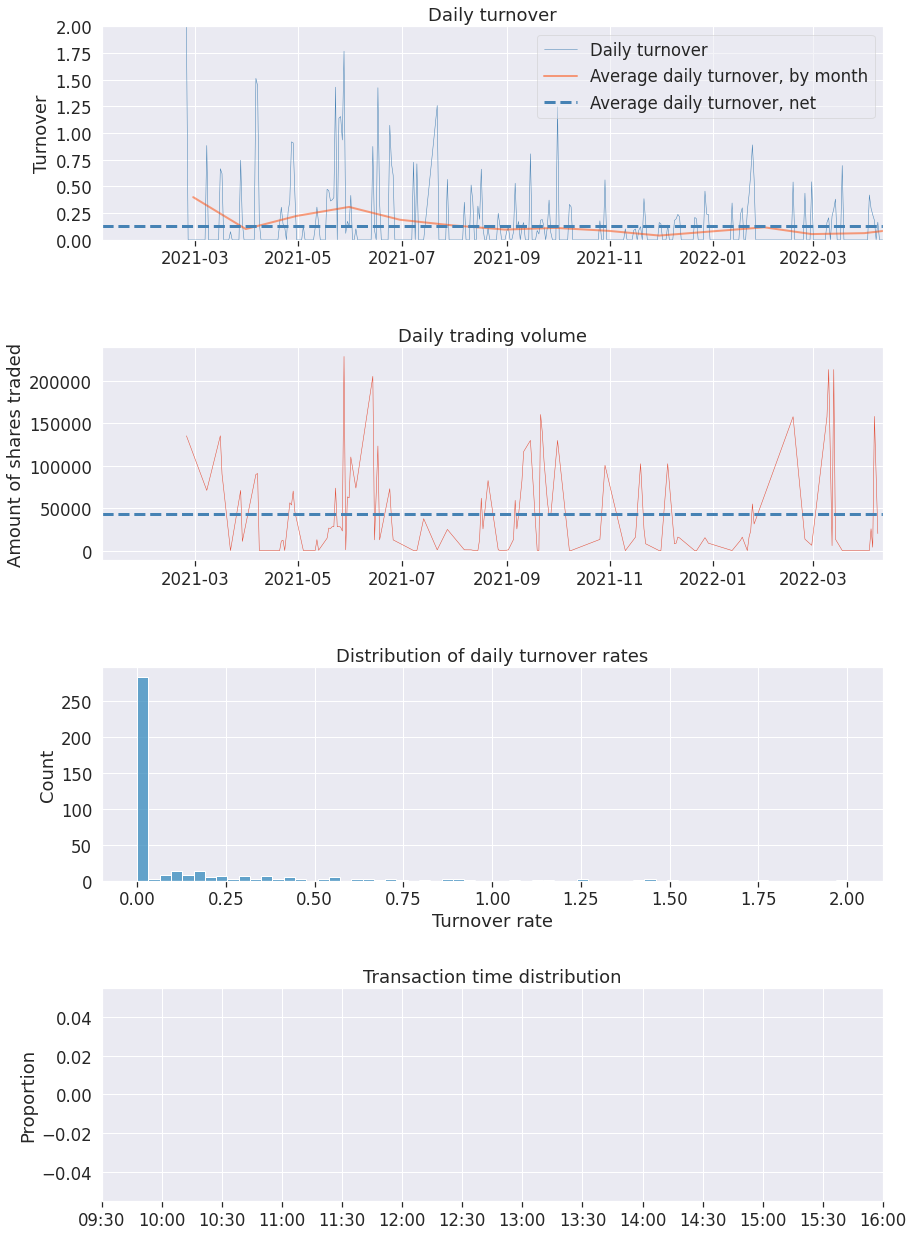

In [95]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1)

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns, live_start_date='2022-04-01')

In [55]:
perf.AMI

2021-01-05 23:59:00+00:00       NaN
2021-01-06 23:59:00+00:00       NaN
2021-01-07 23:59:00+00:00       NaN
2021-01-08 23:59:00+00:00       NaN
2021-01-09 23:59:00+00:00       NaN
                              ...  
2022-04-07 23:59:00+00:00    57.607
2022-04-08 23:59:00+00:00    53.758
2022-04-09 23:59:00+00:00    55.017
2022-04-10 23:59:00+00:00    54.988
2022-04-11 23:59:00+00:00    48.372
Name: AMI, Length: 462, dtype: float64

In [20]:
df_masked

date      open      high       low     close  volume  dividend  \
1191  2021-01-05  0.463867  0.538001  0.427987  0.520253       0       0.0   
1192  2021-01-06  0.523931  0.649441  0.502399  0.605629       0       0.0   
1193  2021-01-07  0.617923  0.652425  0.534492  0.573526       0       0.0   
1194  2021-01-08  0.579135  0.676527  0.513594  0.645674       0       0.0   
1195  2021-01-09  0.649521  0.766602  0.622658  0.739893       0       0.0   
...          ...       ...       ...       ...       ...     ...       ...   
1399  2021-08-01  6.945106  7.012118  6.409302  6.530040       0       0.0   
1400  2021-08-02  6.506082  6.791178  6.315970  6.359280       0       0.0   
1401  2021-08-03  6.363288  6.772628  6.188728  6.517495       0       0.0   
1402  2021-08-04  6.500256  6.929553  6.348952  6.802686       0       0.0   
1403  2021-08-05  6.799140  7.170498  6.706844  7.052274       0       0.0   

      ratio  
1191      1  
1192      1  
1193      1  
1194      1  
1195      1  
...     ...  
1399      1  
1400      1  
1401      1  
1402      1  
1403      1  

[213 rows x 8 columns]

<AxesSubplot:>

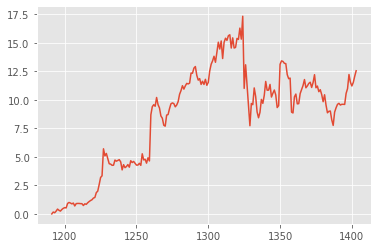

In [28]:
path = "../data/daily/"
df = pd.read_csv(path+'AMI.csv')
mask = (df['date'] >= '2021-01-05') & (df['date'] <= '2021-08-05')
df_masked = df[mask]
df_masked.close.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark (buy and hold AMI)')

In [29]:
df.close

0        0.066615
1        0.054687
2        0.055729
3        0.053197
4        0.048295
          ...    
1654    51.335778
1655    49.306405
1656    49.691042
1657    50.021039
1658    48.928505
Name: close, Length: 1659, dtype: float64

<AxesSubplot:>

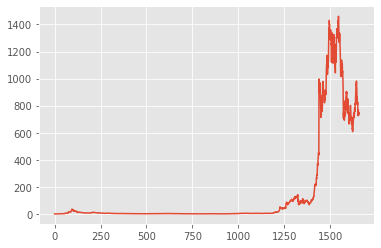

In [30]:
style.use("ggplot")
df.close.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark (buy and hold AMI)')

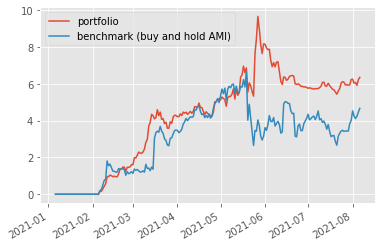

In [31]:
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark (buy and hold AMI)')
plt.legend(loc=2)
plt.show()

In [34]:
perf.returns

2021-01-05 23:59:00+00:00    0.000000
2021-01-06 23:59:00+00:00    0.000000
2021-01-07 23:59:00+00:00    0.000000
2021-01-08 23:59:00+00:00    0.000000
2021-01-09 23:59:00+00:00    0.000000
                               ...   
2021-08-01 23:59:00+00:00   -0.028906
2021-08-02 23:59:00+00:00    0.005454
2021-08-03 23:59:00+00:00   -0.022670
2021-08-04 23:59:00+00:00    0.044221
2021-08-05 23:59:00+00:00    0.017625
Name: returns, Length: 213, dtype: float64

In [33]:
perf.portfolio_value

2021-01-05 23:59:00+00:00     40000.000000
2021-01-06 23:59:00+00:00     40000.000000
2021-01-07 23:59:00+00:00     40000.000000
2021-01-08 23:59:00+00:00     40000.000000
2021-01-09 23:59:00+00:00     40000.000000
                                 ...      
2021-08-01 23:59:00+00:00    281847.852480
2021-08-02 23:59:00+00:00    283385.082595
2021-08-03 23:59:00+00:00    276960.827595
2021-08-04 23:59:00+00:00    289208.320595
2021-08-05 23:59:00+00:00    294305.613595
Name: portfolio_value, Length: 213, dtype: float64

In [32]:
perf.columns

Index(['period_open', 'period_close', 'short_value', 'returns',
       'long_exposure', 'net_leverage', 'portfolio_value', 'gross_leverage',
       'longs_count', 'ending_cash', 'starting_value', 'shorts_count',
       'starting_cash', 'ending_exposure', 'short_exposure', 'long_value',
       'capital_used', 'pnl', 'ending_value', 'orders', 'positions',
       'transactions', 'starting_exposure', 'algorithm_period_return',
       'benchmark_period_return', 'benchmark_volatility', 'excess_return',
       'sortino', 'alpha', 'beta', 'max_leverage', 'treasury_period_return',
       'algo_volatility', 'trading_days', 'max_drawdown', 'period_label',
       'sharpe', 'SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX',
       'AMI'],
      dtype='object')